In [1]:
import pystan

In [2]:
import distutils
print(distutils.__file__)

C:\Users\Harsh\anaconda3\lib\distutils\__init__.py


In [3]:
import numpy as np
import pandas as pd
import scipy 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [26]:
pd_model = """
data {
    int<lower=0> T;
    int<lower=0> W;
    int<lower=0> ND;
    int<lower=0> E[T];
    matrix[ND,T] D;
}

parameters {
    real a0;
    real a1;
    real a2;
    real b0;
    vector[ND] b;
    real theta_u;
    real theta_l;
    real p1_s;
    real p2_s;
}

transformed parameters {
    vector[T] p;
    vector[T] A;
    vector[T] B;
    p[1] = p1_s;
    p[2] = p2_s;
    for (t in 3:T) {
        A[t] = a0 + a1*p[t-1] +a2*p[t-2];
        B[t] = b0 + dot_product(b,col(D,t));
        p[t] = (1/(1+exp(-1*A[t])))*(1 - (1/(1+exp(-1*B[t]))));
    }
}

model {
    p1_s ~ uniform(theta_l,theta_u);
    p2_s ~ uniform(theta_l,theta_u);
    for (t in 1:T) {
        E[t] ~ binomial(W,p[t]);
    }   
}

"""

In [5]:
halflife = pd.DataFrame({
    'lacosamide':[13],
    'levetiracetam':[6],
    'midazolam':[1.5],
    'pentobarbital':[15],
    'phenobarbital':[53],
    'phenytoin':[22],
    'propofol':[1.5],
    'valproate':[8]
    },index=['t1/2'])

halflife = halflife.append(np.log(2) / halflife.rename(index={'t1/2':'k'}))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [6]:
def drug_concentration(d_ts,k):
    k_ts = np.array([ np.exp(-k*t) for t in range(d_ts.shape[1]) ]).T
    conc = np.array([np.convolve(d_ts[i],k_ts[i],'full') for i in range(d_ts.shape[0])])
    return conc

In [8]:
import os
import scipy.io as io
files = os.listdir()

def patient(file):
    window=900
    step=900
    df_temp = pd.DataFrame()
    if '.mat' in file:
        s = io.loadmat(file)
        human_iic_dummy = pd.get_dummies(s['human_iic'][0],dummy_na=False).rename(columns=lambda x: str(x) )
        human_iic_dummy_1hour = pd.DataFrame([np.mean(human_iic_dummy.loc[i:i+window,:],axis=0) for i in range(0,human_iic_dummy.shape[0],step)])
        
        drugs = s['drugs_weightnormalized']
        drugnames = list(map(lambda x: x.replace(' ',''),s['Dnames']))
        drugs_1hr = pd.DataFrame([ np.mean(drugs[i:i+window,:],axis=0) for i in range(0,human_iic_dummy.shape[0],step) ],columns=drugnames)
        change_drug_1hr = drugs_1hr.diff().rename(columns=lambda x: 'd_'+x)
        drugs_1hr = drugs_1hr.join(change_drug_1hr)
        
        for i in range(human_iic_dummy_1hour.shape[0]):
            if (human_iic_dummy_1hour.loc[i,:]==0).all():
                drugs_1hr.loc[i,:] = np.nan 
                human_iic_dummy_1hour.loc[i,:] = np.nan
        
        human_iic_dummy_1hour['IIC'] = 1 - human_iic_dummy_1hour['0.0']
        if '5.0' in human_iic_dummy_1hour.columns:
            human_iic_dummy_1hour['IIC'] = human_iic_dummy_1hour['IIC'] - human_iic_dummy_1hour['5.0']
        change_iic_1hr = human_iic_dummy_1hour.diff().rename(columns=lambda x: 'd_'+x)
        human_iic_dummy_1hour = human_iic_dummy_1hour.join(change_iic_1hr)
        
        df_temp = human_iic_dummy_1hour.join(drugs_1hr)
        df_temp['sid'] = [file.split('.')[0] for i in range(df_temp.shape[0])]
    return df_temp

In [9]:
covariates = pd.read_csv('covariates.csv').set_index('Index').dropna(axis=1)
covariates.index

Index(['sid36', 'sid39', 'sid56', 'sid297', 'sid327', 'sid385', 'sid395',
       'sid400', 'sid403', 'sid406', 'sid424', 'sid450', 'sid456', 'sid490',
       'sid512', 'sid551', 'sid557', 'sid575', 'sid988', 'sid1016', 'sid1025',
       'sid1034', 'sid1038', 'sid1039', 'sid1055', 'sid1056', 'sid1063',
       'sid1337', 'sid1897', 'sid1913', 'sid1915', 'sid1916', 'sid1917',
       'sid1926', 'sid1928', 'sid1956', 'sid1966'],
      dtype='object', name='Index')

In [10]:
def patient_data(sid):
    covariates = pd.read_csv('covariates.csv').set_index('Index').dropna(axis=1)
    k = halflife.loc['k'].to_numpy()
    
    np.random.seed(0)

    #fetch the data
    file = sid + '.mat'
    p = patient(file)

    #setting up the data
    Eobs1 = np.clip(p['IIC'].to_numpy(),0,1)
    Eobs = np.clip(p['IIC'].interpolate(method='cubic').to_numpy(),0,1)
    Dobs = p[['lacosamide', 'levetiracetam', 'midazolam', 
                    'pentobarbital','phenobarbital', 'phenytoin', 'propofol', 'valproate']].fillna(0).to_numpy().T
    T = Eobs.shape[0]

    #PK
    d_conc = drug_concentration(Dobs,k)[:,:T]
    return Eobs1, Eobs, T, d_conc

In [11]:
sid1916 = patient_data('sid1916')

In [32]:
W=900
Eobs1, Eobs, T, D = sid1916
E = (Eobs*W).astype(int)

(91,)
(8, 91)
91


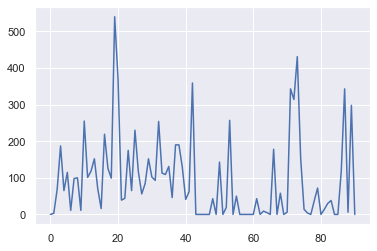

In [30]:
plt.plot(E)
print(E.shape)
print(D.shape)
print(T)

In [35]:
data_feed = {'T': T, 'W': W, 'ND': 8, 'E': E, 'D': D}
print(data_feed)


{'T': 91, 'W': 900, 'ND': 8, 'E': array([  0,   3,  69, 187,  65, 115,  11,  98, 100,  11, 255, 101, 118,
       152,  70,  16, 219, 126,  99, 540, 369,  39,  44, 175,  65, 230,
       117,  56,  84, 152, 102,  93, 254, 113, 109, 131,  46, 190, 190,
       129,  41,  62, 359,   0,   0,   0,   0,   0,  43,   0, 143,   0,
        19, 257,   0,  50,   0,   0,   0,   0,   0,  43,   0,   9,   5,
         0, 178,   0,  58,   0,   6, 343, 314, 431, 153,  14,   4,   0,
        37,  72,   0,  14,  30,  38,   0,   0, 118, 343,   6, 298,   0]), 'D': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00,

In [37]:
sm = pystan.StanModel(model_code=pd_model)
fit = sm.sampling(data=data_feed, iter=10)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1a592e43ff9fe498d44cc2ccf148e37 NOW.


RuntimeError: Initialization failed.